In [1]:
import numpy as np
import matplotlib.pyplot as plt
import skimage as ski
import xml.dom.minidom as minidom
import glob
import torch
import cv2
import os
import  xml.dom.minidom
from torch.utils.data import Dataset, DataLoader 

In [2]:
%pip install ultralytics
import ultralytics
ultralytics.checks()
from ultralytics import YOLO

Ultralytics YOLOv8.2.93 🚀 Python-3.10.12 torch-2.0.0+cpu CPU (Intel Xeon 2.20GHz)
Setup complete ✅ (4 CPUs, 31.4 GB RAM, 5845.9/8062.4 GB disk)


First create a folder structure to organize our train, validation and test datasets:

In [3]:
# Create train, val and test paths
os.mkdir('/kaggle/working/train')
os.mkdir('/kaggle/working/val')
os.mkdir('/kaggle/working/test')

os.mkdir('/kaggle/working/train/img')
os.mkdir('/kaggle/working/train/labels')
os.mkdir('/kaggle/working/val/img')
os.mkdir('/kaggle/working/val/labels')
os.mkdir('/kaggle/working/test/img')
os.mkdir('/kaggle/working/test/labels')

/opt/conda/lib/python3.10/site-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.23.5
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


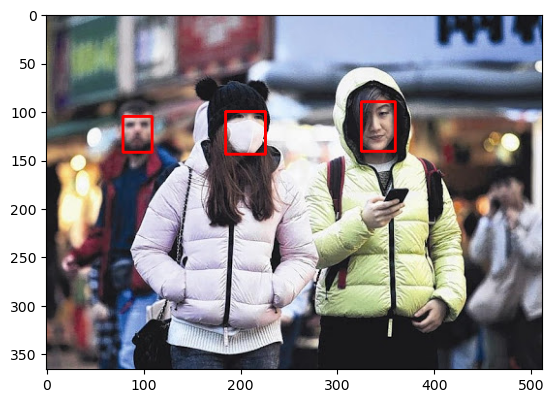

<?xml version="1.0" ?>
<annotation>
	
    
	<folder>images</folder>
	
    
	<filename>maksssksksss0.png</filename>
	
    
	<size>
		
        
		<width>512</width>
		
        
		<height>366</height>
		
        
		<depth>3</depth>
		
    
	</size>
	
    
	<segmented>0</segmented>
	
    
	<object>
		
        
		<name>without_mask</name>
		
        
		<pose>Unspecified</pose>
		
        
		<truncated>0</truncated>
		
        
		<occluded>0</occluded>
		
        
		<difficult>0</difficult>
		
        
		<bndbox>
			
            
			<xmin>79</xmin>
			
            
			<ymin>105</ymin>
			
            
			<xmax>109</xmax>
			
            
			<ymax>142</ymax>
			
        
		</bndbox>
		
    
	</object>
	
    
	<object>
		
        
		<name>with_mask</name>
		
        
		<pose>Unspecified</pose>
		
        
		<truncated>0</truncated>
		
        
		<occluded>0</occluded>
		
        
		<difficult>0</difficult>
		
        
		<bndbox>
			
            
			<xmin>185</xmin>
			
            
			<ymin>10

In [4]:
images_path = "/kaggle/input/face-mask-detection/images/*"
annot_path = "/kaggle/input/face-mask-detection/annotations/*"

images = ski.io.imread_collection(images_path).files 
annotations = sorted(glob.glob(annot_path))


# Show sample image and print bounding boxes from the corresponding label

test_img = ski.io.imread(images[0])

dom = xml.dom.minidom.parse(annotations[0])
root = dom.documentElement
objects = dom.getElementsByTagName("object")

coord_list = [
    [
        bndbox.getElementsByTagName('xmin')[0].childNodes[0].data,
        bndbox.getElementsByTagName('ymin')[0].childNodes[0].data,
        bndbox.getElementsByTagName('xmax')[0].childNodes[0].data,
        bndbox.getElementsByTagName('ymax')[0].childNodes[0].data
    ]
    for bndbox in root.getElementsByTagName('bndbox')
]

for coords in coord_list:
    cv2.rectangle(
        test_img, 
        (int(coords[0]), int(coords[1])),
        (int(coords[2]), int(coords[3])),
        (255, 0, 0),
        2
    )

plt.imshow(test_img), plt.show()


# Also show xml format of the label

print(dom.toprettyxml())

### The annotation format is currently in Pascal Voc xml, which is currently not suitable for YOLO. We have to convert the bounding boxes for txt format:

In [5]:
def to_yolo_format(bbox, w, h):
    """
    Converts the bounding box format into one suitable for YOLO.
    """
    x_center = ((bbox[2] + bbox[0]) / 2) / w
    y_center = ((bbox[3] + bbox[1]) / 2 ) / h
    width = (bbox[2] - bbox[0]) / w
    height = (bbox[3] - bbox[1]) / h
    
    return [x_center, y_center, width, height]


def from_yolo_format(bbox, w, h):
    """
    Converts the bounding box from YOLO format back to the original format.
    """
    w_half_len = (bbox[2] + w) / 2
    h_half_len = (bbox[3] + h) / 2
    xmin = int((bbox[0] + w) - w_half_len)
    ymin = int((bbox[1] + h) - h_half_len)
    xmax = int((bbox[0] + w) + w_half_len)
    ymax = int((bbox[1] + h) + h_half_len)
    
    return [xmin, ymin, xmax, ymax]


classes = ['with_mask', 'without_mask', 'mask_weared_incorrect']

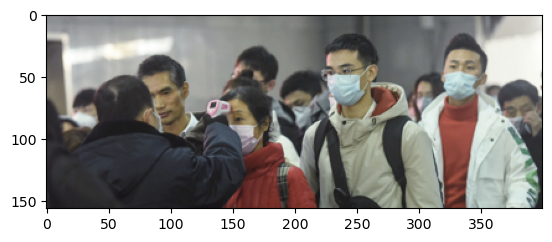


<annotation>
    <folder>images</folder>
    <filename>maksssksksss1.png</filename>
    <size>
        <width>400</width>
        <height>156</height>
        <depth>3</depth>
    </size>
    <segmented>0</segmented>
    <object>
        <name>with_mask</name>
        <pose>Unspecified</pose>
        <truncated>0</truncated>
        <occluded>0</occluded>
        <difficult>0</difficult>
        <bndbox>
            <xmin>321</xmin>
            <ymin>34</ymin>
            <xmax>354</xmax>
            <ymax>69</ymax>
        </bndbox>
    </object>
    <object>
        <name>with_mask</name>
        <pose>Unspecified</pose>
        <truncated>0</truncated>
        <occluded>0</occluded>
        <difficult>0</difficult>
        <bndbox>
            <xmin>224</xmin>
            <ymin>38</ymin>
            <xmax>261</xmax>
            <ymax>73</ymax>
        </bndbox>
    </object>
    <object>
        <name>with_mask</name>
        <pose>Unspecified</pose>
        <truncated>0</truncated

In [6]:
class mask_dataset(Dataset):
    
    def __init__(self, img_path, annot_path):

        self.images = [ski.io.imread(img) for img in ski.io.imread_collection(img_path).files]
        self.labels = [
            open(label).read()
            for label in sorted(glob.glob(annot_path))
        ]
        
    def __getitem__(self, idx):
        
        image = self.images[idx]
        label = self.labels[idx]
        
        return image, label
    

dataset = mask_dataset(images_path, annot_path)

test_data = dataset[1]
plt.imshow(test_data[0]), plt.show()
print(test_data[1])

# Build and train model

In [7]:
model = YOLO('yolov9s.pt')
#model.train(data = , epochs = 30, batch = 32)

100%|██████████| 14.7M/14.7M [00:00<00:00, 30.9MB/s]


Testing prediction with the vanilla model:


0: 480x640 4 persons, 3 handbags, 1 cell phone, 440.4ms
Speed: 11.8ms preprocess, 440.4ms inference, 21.1ms postprocess per image at shape (1, 3, 480, 640)


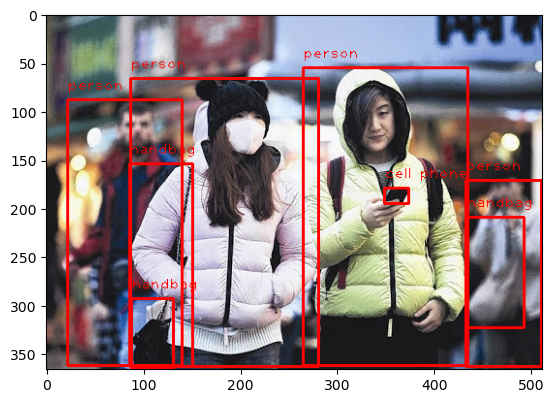

(<matplotlib.image.AxesImage at 0x7bf04e272fb0>, None)

In [8]:
result_img = ski.io.imread(images[0])

result = model.predict(result_img)
#print(res)
#result_img, _ = predict_and_detect(model, test_img, classes=[], conf=0.5)

result_img = ski.io.imread(images[0])

for box in result[0].boxes:
    cv2.rectangle(result_img, (int(box.xyxy[0][0]), int(box.xyxy[0][1])),
                    (int(box.xyxy[0][2]), int(box.xyxy[0][3])), (255, 0, 0), 2)
    cv2.putText(result_img, f"{result[0].names[int(box.cls[0])]}",
                (int(box.xyxy[0][0]), int(box.xyxy[0][1]) - 10),
                cv2.FONT_HERSHEY_PLAIN, 1, (255, 0, 0), 1)

plt.imshow(result_img), plt.show()

Next step is to train the model for mask recognition: